Loaded 444 training samples


,audios_train,label
0,audio_1261.wav,1.0
1,audio_942.wav,1.5
2,audio_1110.wav,1.5
3,audio_1024.wav,1.5
4,audio_538.wav,2.0


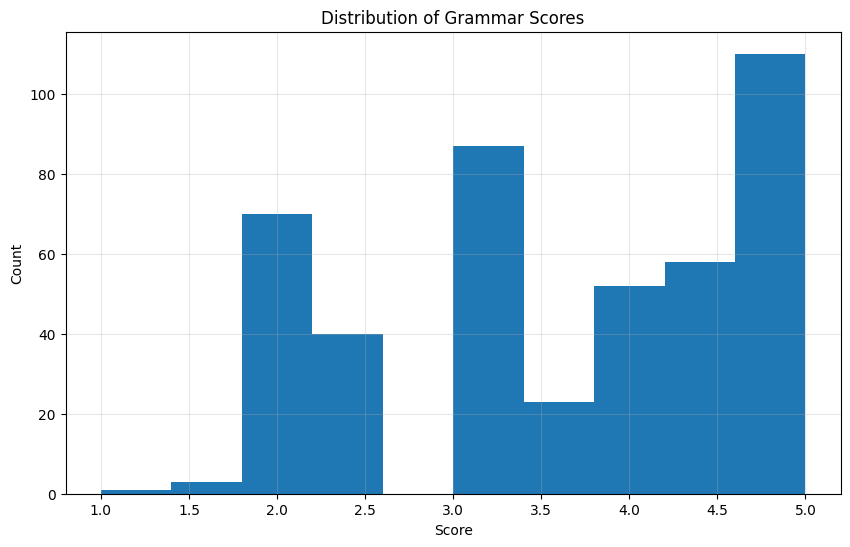

Extracting features from training files...


KeyError: 'filename'

In [5]:
# Grammar Scoring Engine for Voice Samples
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
import soundfile as sf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import joblib
import warnings
from tqdm.notebook import tqdm
import IPython.display as ipd
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Define the directories where audio files are stored
TRAIN_AUDIO_DIR = './audios_train'
TEST_AUDIO_DIR = './audios_test'
AUDIO_DIR = './audio_files'  # Keep this for backward compatibility with other functions

# Create directories if they don't exist
for directory in [TRAIN_AUDIO_DIR, TEST_AUDIO_DIR, AUDIO_DIR]:
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Created directory {directory}")

# Function to extract features from a single audio file
def extract_features(audio_file, audio_dir=AUDIO_DIR):
    """Extract audio features from a single file."""
    try:
        # Load audio file
        y, sr = librosa.load(os.path.join(audio_dir, audio_file), sr=None)
        
        # Basic features
        duration = librosa.get_duration(y=y, sr=sr)
        tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
        
        # Spectral features
        spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)[0])
        spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr)[0])
        spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr)[0])
        
        # Rhythm features
        zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y=y)[0])
        
        # MFCC features (for pronunciation patterns)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfcc_means = np.mean(mfccs, axis=1)
        mfcc_vars = np.var(mfccs, axis=1)
        
        # Chroma features (for tonal content)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        chroma_means = np.mean(chroma, axis=1)
        
        # Energy features
        rmse = np.mean(librosa.feature.rms(y=y)[0])
        
        # Pause detection (silence ratio)
        non_silent = librosa.effects.split(y, top_db=30)
        non_silent_duration = 0
        for start, end in non_silent:
            non_silent_duration += (end - start) / sr
        silence_ratio = 1 - (non_silent_duration / duration)
        
        # Harmonic and percussive components
        y_harmonic, y_percussive = librosa.effects.hpss(y)
        harmonic_ratio = np.sum(y_harmonic**2) / np.sum(y**2) if np.sum(y**2) > 0 else 0
        
        # Fundamental frequency variations
        pitch = librosa.yin(y, fmin=50, fmax=500)
        pitch_mean = np.mean(pitch)
        pitch_std = np.std(pitch)
        
        # Collect all features
        features = {
            'duration': duration,
            'tempo': tempo,
            'spectral_centroid': spectral_centroid,
            'spectral_bandwidth': spectral_bandwidth,
            'spectral_rolloff': spectral_rolloff,
            'zero_crossing_rate': zero_crossing_rate,
            'rmse': rmse,
            'silence_ratio': silence_ratio,
            'harmonic_ratio': harmonic_ratio,
            'pitch_mean': pitch_mean,
            'pitch_std': pitch_std
        }
        
        # Add MFCC features
        for i, (mean, var) in enumerate(zip(mfcc_means, mfcc_vars)):
            features[f'mfcc_{i+1}_mean'] = mean
            features[f'mfcc_{i+1}_var'] = var
            
        # Add chroma features
        for i, mean in enumerate(chroma_means):
            features[f'chroma_{i+1}'] = mean
            
        return features
    
    except Exception as e:
        print(f"Error processing {audio_file}: {e}")
        return None

# Function to extract features from a batch of audio files
def extract_features_batch(audio_files, audio_dir=AUDIO_DIR):
    """Extract features from a batch of audio files."""
    all_features = []
    
    for audio_file in tqdm(audio_files, desc="Extracting audio features"):
        features = extract_features(audio_file, audio_dir)
        if features:
            all_features.append(features)
    
    # Convert to DataFrame
    feature_df = pd.DataFrame(all_features)
    
    return feature_df

# Load the training data
train_data = pd.read_csv('train.csv')
print(f"Loaded {len(train_data)} training samples")
display(train_data.head())

# Examine the distribution of grammar scores
plt.figure(figsize=(10, 6))
train_data['label'].hist(bins=10)
plt.title('Distribution of Grammar Scores')
plt.xlabel('Score')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)
plt.show()

# Extract features from training audio files
print("Extracting features from training files...")
# For training data
X_train_df = extract_features_batch(train_data['filename'], TRAIN_AUDIO_DIR)

# For test data
X_test_df = extract_features_batch(test_data['filename'], TEST_AUDIO_DIR)

# Handle any missing values
X_train_df = X_train_df.fillna(0)
print(f"Extracted {X_train_df.shape[1]} features from {X_train_df.shape[0]} audio files")

# Get labels
y_train = train_data['label'].values

# Split data for validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_df, y_train, test_size=0.2, random_state=42
)
print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")

# Store feature names for later use
feature_names = X_train.columns.tolist()

# Try different models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'SVR': SVR(kernel='rbf')
}

results = {}
best_model = None
best_score = float('inf')
best_model_name = None

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Create a pipeline with scaling
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    
    # Train the model
    pipeline.fit(X_train, y_train)
    
    # Evaluate on validation set
    y_pred = pipeline.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    
    print(f"{name} - MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")
    
    # Store results
    results[name] = {
        'mse': mse,
        'mae': mae,
        'r2': r2,
        'predictions': y_pred
    }
    
    # Save the best model
    if mse < best_score:
        best_score = mse
        best_model = pipeline
        best_model_name = name

print(f"\nBest model: {best_model_name} with MSE: {best_score:.4f}")

# Plot actual vs. predicted values for the best model
plt.figure(figsize=(12, 8))
plt.scatter(y_val, results[best_model_name]['predictions'], alpha=0.7)
plt.plot([1, 5], [1, 5], 'r--')
plt.title(f'Actual vs. Predicted Grammar Scores - {best_model_name}')
plt.xlabel('Actual Score')
plt.ylabel('Predicted Score')
plt.grid(True, alpha=0.3)
plt.show()

# Train the best model on the full training set
print("Training best model on full training set...")
best_model.fit(X_train_df, y_train)

# Save the model
model_path = 'grammar_scoring_model.pkl'
joblib.dump(best_model, model_path)
print(f"Model saved to {model_path}")

# Visualize feature importance if applicable
if best_model_name in ['Random Forest', 'Gradient Boosting']:
    feature_importance = best_model.named_steps['model'].feature_importances_
    importance_df = pd.DataFrame({
        'Feature': X_train_df.columns,
        'Importance': feature_importance
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    plt.barh(importance_df['Feature'][:15], importance_df['Importance'][:15])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title(f'Top 15 Feature Importance - {best_model_name}')
    plt.tight_layout()
    plt.show()

# Load test data
test_data = pd.read_csv('test.csv')
print(f"Loaded {len(test_data)} test samples")
display(test_data.head())

# Extract features from test data
print("Extracting features from test files...")
X_test_df = extract_features_batch(test_data['filename'])

# Handle any missing values
X_test_df = X_test_df.fillna(0)

# Ensure all required features are present
for feature in feature_names:
    if feature not in X_test_df.columns:
        X_test_df[feature] = 0

# Keep only the features the model knows about
X_test_df = X_test_df[feature_names]

# Make predictions
predictions = best_model.predict(X_test_df)

# Ensure all predictions are within valid range
predictions = np.clip(predictions, 1.0, 5.0)

# Create submission DataFrame
submission = pd.DataFrame({
    'filename': test_data['filename'],
    'label': predictions
})

# Save predictions to CSV
output_csv = 'predictions.csv'
submission.to_csv(output_csv, index=False)
print(f"Predictions saved to {output_csv}")
display(submission.head())

# Function to predict a single audio file
def predict_audio(audio_file, model=None, feature_names=None):
    """Predict grammar score for a single audio file."""
    if model is None:
        model = joblib.load('grammar_scoring_model.pkl')
    
    # Extract features
    features = extract_features(audio_file)
    if not features:
        return None
    
    # Convert to DataFrame
    features_df = pd.DataFrame([features])
    
    # Ensure all required features are present
    if feature_names:
        for feature in feature_names:
            if feature not in features_df.columns:
                features_df[feature] = 0
        
        # Keep only the features the model knows about
        features_df = features_df[feature_names]
    
    # Make prediction
    score = model.predict(features_df)[0]
    
    # Ensure score is within valid range
    score = max(1.0, min(5.0, score))
    
    return score

# Example: Test with one audio file from the test set
if len(test_data) > 0:
    sample_audio = test_data['filename'].iloc[0]
    print(f"Testing with {sample_audio}...")
    
    # Display audio if possible
    try:
        audio_path = os.path.join(AUDIO_DIR, sample_audio)
        if os.path.exists(audio_path):
            ipd.display(ipd.Audio(audio_path))
        else:
            print(f"Audio file not found: {audio_path}")
    except Exception as e:
        print(f"Cannot display audio: {e}")
    
    # Predict
    score = predict_audio(sample_audio, best_model, feature_names)
    if score is not None:
        print(f"Predicted grammar score: {score:.2f}/5.0")
        
        # Score interpretation
        if score < 2.0:
            print("Interpretation: Basic grammar skills, needs significant improvement.")
        elif score < 3.0:
            print("Interpretation: Intermediate grammar skills, some errors present.")
        elif score < 4.0:
            print("Interpretation: Good grammar skills, minor errors.")
        else:
            print("Interpretation: Excellent grammar skills, few to no errors.")
    else:
        print("Failed to predict score for this audio file.")

# Function to test with user-uploaded audio
def test_with_uploaded_audio(file_upload_path):
    """Test the model with an uploaded audio file.
    
    Args:
        file_upload_path: Path to the uploaded audio file
    """
    # Copy the file to the audio directory
    import shutil
    filename = os.path.basename(file_upload_path)
    dest_path = os.path.join(AUDIO_DIR, filename)
    
    if file_upload_path != dest_path:  # Only copy if paths are different
        shutil.copy2(file_upload_path, dest_path)
    
    # Display audio
    ipd.display(ipd.Audio(dest_path))
    
    # Predict score
    score = predict_audio(filename, best_model, feature_names)
    
    if score is not None:
        print(f"Predicted grammar score: {score:.2f}/5.0")
        
        # Score interpretation
        if score < 2.0:
            print("Interpretation: Basic grammar skills, needs significant improvement.")
        elif score < 3.0:
            print("Interpretation: Intermediate grammar skills, some errors present.")
        elif score < 4.0:
            print("Interpretation: Good grammar skills, minor errors.")
        else:
            print("Interpretation: Excellent grammar skills, few to no errors.")
    else:
        print("Failed to predict score for this audio file.")

# Uncomment and use this function to test with your own audio file
# test_with_uploaded_audio('/path/to/your/audio/file.wav')

# More helpful visualizations and explanations

# Plot one audio file and its features
if len(train_data) > 0:
    sample_file = train_data['filename'].iloc[0]
    sample_score = train_data['label'].iloc[0]
    print(f"Visualizing {sample_file} with score {sample_score}")
    
    try:
        # Load audio file
        audio_path = os.path.join(AUDIO_DIR, sample_file)
        if os.path.exists(audio_path):
            y, sr = librosa.load(audio_path, sr=None)
            
            # Plot waveform
            plt.figure(figsize=(14, 5))
            plt.subplot(2, 1, 1)
            librosa.display.waveshow(y, sr=sr)
            plt.title(f'Waveform - Score: {sample_score}')
            
            # Plot spectrogram
            plt.subplot(2, 1, 2)
            D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
            librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
            plt.colorbar(format='%+2.0f dB')
            plt.title('Spectrogram')
            plt.tight_layout()
            plt.show()
            
            # Extract and print key features
            features = extract_features(sample_file)
            if features:
                print("Key features:")
                for key in ['duration', 'tempo', 'rmse', 'spectral_centroid', 'silence_ratio', 'pitch_mean']:
                    print(f"- {key}: {features[key]:.4f}")
        else:
            print(f"Audio file not found: {audio_path}")
    except Exception as e:
        print(f"Cannot visualize audio: {e}")

# Plot relationship between key features and grammar scores
if X_train_df is not None and len(X_train_df) > 0:
    key_features = ['duration', 'tempo', 'rmse', 'spectral_centroid', 'silence_ratio']
    feature_df = X_train_df.copy()
    feature_df['score'] = y_train
    
    plt.figure(figsize=(15, 10))
    for i, feature in enumerate(key_features):
        plt.subplot(2, 3, i+1)
        plt.scatter(feature_df[feature], feature_df['score'], alpha=0.5)
        plt.title(f'{feature} vs. Score')
        plt.xlabel(feature)
        plt.ylabel('Grammar Score')
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Interactive function for real-time prediction
def setup_upload_widget():
    """Set up a file upload widget for interactive testing."""
    from ipywidgets import FileUpload
    upload_widget = FileUpload(accept='.wav', multiple=False)
    display(upload_widget)
    return upload_widget

def process_upload(change, widget, feature_names=None):
    """Process uploaded audio file and make predictions."""
    if not change['new']:
        return
    
    # Get the uploaded file
    uploaded_file = list(widget.value.values())[0]
    filename = uploaded_file['name']
    
    # Save the file
    with open(os.path.join(AUDIO_DIR, filename), 'wb') as f:
        f.write(uploaded_file['content'])
    
    print(f"File {filename} uploaded successfully!")
    
    # Display audio
    ipd.display(ipd.Audio(os.path.join(AUDIO_DIR, filename)))
    
    # Predict score
    score = predict_audio(filename, best_model, feature_names)
    
    if score is not None:
        print(f"Predicted grammar score: {score:.2f}/5.0")
        
        # Score interpretation
        if score < 2.0:
            print("Interpretation: Basic grammar skills, needs significant improvement.")
        elif score < 3.0:
            print("Interpretation: Intermediate grammar skills, some errors present.")
        elif score < 4.0:
            print("Interpretation: Good grammar skills, minor errors.")
        else:
            print("Interpretation: Excellent grammar skills, few to no errors.")
    else:
        print("Failed to predict score for this audio file.")

# Uncomment to create an upload widget and enable the callback
# upload_widget = setup_upload_widget()
# upload_widget.observe(lambda change: process_upload(change, upload_widget, feature_names), names='value')

print("\nGrammar Scoring Engine - Complete!")
print("To use this model for your own audio files:")
print("1. Place your WAV files in the 'audio_files' directory")
print("2. Use the predict_audio() function with the filename")
print("3. Or uncomment the upload widget code for interactive testing")